This follows the Pion and 2SC notes document and we use $\mu$ and $\mu_I$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from tqdm import tqdm
import scipy.optimize as optimize

In [2]:
Λ_cutoff = 2000
Nc = 3
mσ = 599.99
mq = 300
mπ = 140
fπ = 93
g = mq/fπ

def C(p):
    return np.real(2-2*np.emath.sqrt(4*mq**2/(p**2)-1)*np.arctan(1/(np.emath.sqrt(4*mq**2/(p**2)-1))))

def dC(p):
    return np.real(4*mq**2/(p**4*np.emath.sqrt(4*mq**2/(p**2)-1))*np.arctan(1/(np.emath.sqrt(4*mq**2/(p**2)-1)))-1/(p**2))

Cσ = C(mσ)
Cπ = C(mπ)
dCπ = dC(mπ)

m0_tree = np.sqrt((mσ**2 - 3*mπ**2)/2)
λ0_tree = 3*(mσ**2 - 3*mπ**2)/fπ**2
h0_tree = (mπ**2*fπ)**(1/3)


m0 = np.sqrt((mσ**2-3*mπ**2)/2 + 2*Nc*mq**2/((4*np.pi)**2*fπ**2)*(4*mq**2 + (mσ**2-4*mq**2)*Cσ - mσ**2*Cπ - (mσ**2-3*mπ**2)*mπ**2*dCπ))

λ0 = 3*(mσ**2-mπ**2)/fπ**2 + 12*Nc*mq**2/((4*np.pi)**2*fπ**4)*((mσ**2-4*mq**2)*(Cσ - Cπ - mπ**2*dCπ) + mπ**4*dCπ)

h0 = -mπ**2*fπ**2*(1-4*Nc*mq**2/((4*np.pi)**2*fπ**2)*mπ**2*dCπ)/fπ

g0 = mq/fπ
gΔ = 1.5*g0
mΔ = 900
λ3 = λ0
λΔ = λ0/4
print(m0_tree)
print(λ0_tree)
print(h0_tree)

388.0644277049882
104.47034342698578
122.15549464477317


In [3]:
def E(p, m):
    return np.sqrt(p**2 + m**2)

def EΔ(p, m, Δ, μ_bar):  
    return np.sqrt((E(p, m) + μ_bar)**2 + Δ**2)

def step(x):
    if x >= 0:
        return 1
    else:
        return 0

In [4]:
def Ωϕρ(ϕ, ρ, μI):
    line1 = 3/4*mπ**2*fπ**2*(1 - 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*mπ**2*dCπ)*(ϕ**2 + ρ**2)/(mq**2)
    line2 = -1/4*mσ**2*fπ**2*(1 + 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*((1-4*mq**2/(mσ**2))*Cσ + 4*mq**2/(mσ**2) - Cπ - mπ**2*dCπ))*(ϕ**2 + ρ**2)/(mq**2)
    line3 = -μI**2/2*fπ**2*(1 - 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*(np.log((ϕ**2 + ρ**2)/(mq**2) + Cπ + mπ**2*dCπ)))*ρ**2/(mq**2)
    line4 = 1/8*mσ**2*fπ**2*(1 - 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*(4*mq**2/(mσ**2)*(np.log((ϕ**2 + ρ**2)/(mq**2)) - 3/2) - (1 - 4*mq**2/(mσ**2))*Cσ + Cπ + mπ**2*dCπ))*(ϕ**2 + ρ**2)**2/(mq**4)
    line5 = -1/8*mπ**2*fπ**2*(1 - 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*mπ**2*dCπ)*(ϕ**2 + ρ**2)**2/(mq**4) - mπ**2*fπ**2*(1 - 4*mq**2*Nc/((4*np.pi)**2*fπ**2)*mπ**2*dCπ)*ϕ/mq
    return line1 + line2 + line3 + line4 + line5

def Ωϕρ_finite(ϕ, ρ, μI):
    if ρ == 0:
        return 0
    else:
        def integrand(p):
            return p**2*(np.sqrt((E(p, ϕ) + μI/2)**2 + ρ**2) + np.sqrt((E(p, ϕ) - μI/2)**2 + ρ**2)
                        -2*np.sqrt(p**2 + ϕ**2 + ρ**2)
                        -1/4*μI**2*ρ**2/(p**2 + ϕ**2 + ρ**2)**(3/2))
        integral, err = integrate.quad(integrand, 0, Λ_cutoff)
        return -2*Nc*integral*4*np.pi/((2*np.pi)**3)

def Ωϕρμ(ϕ, ρ, μ, μI):
    #Define relevant chemcial potentials
    μu = μ + 1/2*μI
    μd = μ - 1/2*μI
    #This can be done analytically!
    if ρ == 0:
        def integrand1(p):
            return p**2*(μu- E(p, ϕ))*step(μu - E(p, ϕ))
        def integrand2(p):
            return p**2*(μd- E(p, ϕ))*step(μd - E(p, ϕ))
        def integrand3(p):
            return p**2*(-μu- E(p, ϕ))*step(-μu - E(p, ϕ))
        def integrand4(p):
            return p**2*(-μd- E(p, ϕ))*step(-μd - E(p, ϕ))
        
        integral1, err1 = integrate.quad(integrand1, 0, Λ_cutoff)
        integral2, err2 = integrate.quad(integrand2, 0, Λ_cutoff)
        integral3, err3 = integrate.quad(integrand3, 0, Λ_cutoff)
        integral4, err4 = integrate.quad(integrand4, 0, Λ_cutoff)
        
        return -2*Nc*(integral1 + integral2 + integral3 + integral4)*4*np.pi/((2*np.pi)**3)
    
    else:
        def integrand1(p):
            return p**2*((μ - np.sqrt((E(p, ϕ) + μI/2)**2 + ρ**2))*step(μ - np.sqrt((E(p, ϕ) + μI/2)**2 + ρ**2)))
        
        def integrand2(p):
            return p**2*((μ - np.sqrt((E(p, ϕ) - μI/2)**2 + ρ**2))*step(μ - np.sqrt((E(p, ϕ) - μI/2)**2 + ρ**2)))
        
        def integrand3(p):
            return p**2*((-μ - np.sqrt((E(p, ϕ) + μI/2)**2 + ρ**2))*step(-μ - np.sqrt((E(p, ϕ) + μI/2)**2 + ρ**2)))
        
        def integrand4(p):
            return p**2*((-μ - np.sqrt((E(p, ϕ) - μI/2)**2 + ρ**2))*step(-μ - np.sqrt((E(p, ϕ) - μI/2)**2 + ρ**2)))
        
        integral1, err1 = integrate.quad(integrand1, 0, Λ_cutoff)
        
        integral2, err2 = integrate.quad(integrand2, 0, Λ_cutoff)

        integral3, err3 = integrate.quad(integrand3, 0, Λ_cutoff)
        
        integral4, err4 = integrate.quad(integrand4, 0, Λ_cutoff)
        
        return -2*Nc*(integral1 + integral2 + integral3 + integral4)*4*np.pi/((2*np.pi)**3)

def Ωϕρ_tot_zero_ρ(ϕ, μ, μe):
    return (Ωϕρ(ϕ, 0, μe) + Ωϕρ_finite(ϕ, 0, μe) + Ωϕρμ(ϕ, 0, μ, μe))/fπ**4

def Ωϕρ_tot(ϕρ, μ, μe):
    ϕ, ρ = ϕρ
    return (Ωϕρ(ϕ, ρ, μe) + Ωϕρ_finite(ϕ, ρ, μe) + Ωϕρμ(ϕ, ρ, μ, μe))/fπ**4

In [5]:
def Ωϕ(ϕ):
    if ϕ == 0:
        return 0 
    else: 
        return  h0*fπ*ϕ/mq - 1/2*m0**2*fπ**2*ϕ**2/(mq**2) + 1/24*λ0*fπ**4*ϕ**4/(mq**4) + 2*mq**4/((4*np.pi)**2)*(np.log(mq**2/(ϕ**2)) -(Cπ+mπ**2*dCπ))*ϕ**4/(mq**4) + 2*Nc*mq**4/((4*np.pi)**2)*(3/2)*ϕ**4/(mq**4)

def ΩϕΔ(ϕ, Δ, μ):
    if ϕ == 0 and Δ == 0:
        return 0
    if ϕ == 0:
        return  (mΔ**2 - 4*μ**2)/(gΔ**2)*Δ**2 - 16/((4*np.pi)**2)*(np.log(mq**2/(Δ**2))-(Cπ+mπ**2*dCπ))*μ**2*Δ**2 + λΔ/(6*gΔ**4)*Δ**4 + 6/((4*np.pi)**2)*Δ**4 + 4/((4*np.pi)**2)*(np.log(mq**2/(Δ**2))-(Cπ + mπ**2*dCπ))*(Δ**4)
    if Δ ==0:
        return   4*mq**4/((4*np.pi)**2)*(np.log((mq**2)/(ϕ**2)) -(Cπ+mπ**2*dCπ))*ϕ**4/(mq**4)
    else:
        return 1/12*λ3*fπ**2/(gΔ**2*mq**2)*Δ**2*ϕ**2 + 12/((4*np.pi)**2)*ϕ**2*Δ**2 + (mΔ**2 - 4*μ**2)/(gΔ**2)*Δ**2 - 16/((4*np.pi)**2)*(np.log(mq**2/(Δ**2+ϕ**2))-(Cπ+mπ**2*dCπ))*μ**2*Δ**2 + λΔ/(6*gΔ**4)*Δ**4 + 6/((4*np.pi)**2)*Δ**4 + 4/((4*np.pi)**2)*(np.log(mq**2/(Δ**2+ϕ**2))-(Cπ + mπ**2*dCπ))*(Δ**4) +  8/((4*np.pi)**2)*(np.log(mq**2/(Δ**2+ϕ**2))-(Cπ + mπ**2*dCπ))*Δ**2*ϕ**2 + 4*mq**4/((4*np.pi)**2)*(np.log((mq**2)/(ϕ**2+Δ**2)) -(Cπ+mπ**2*dCπ))*ϕ**4/(mq**4)
    
def Ω_num(ϕ, Δ, μ):
    def integrand(p):
        if Δ == 0:
            return 0
        else:
            return p**2*(EΔ(p, ϕ, Δ, μ) + EΔ(p, ϕ, Δ, -μ) - 2*np.sqrt(p**2 + ϕ**2 + Δ**2) - Δ**2*μ**2/((p**2 + ϕ**2 + Δ**2)**(3/2))
                        )

    integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit = 50)

    return 2*integral/(np.pi**2)
    
def Ωμ(ϕ, Δ, μ, μI):

    μ_u = μ + 1/2*μI
    μ_d = μ - 1/2*μI
    δμ = μI/2

    if Δ != 0:

        def integrand_ub(p):
            if μ_u < 0:
                return p**2*(-μ_u - E(p, ϕ))*step(-μ_u - E(p, ϕ))
            else:
                return p**2*(μ_u - E(p, ϕ))*step(μ_u - E(p, ϕ))

        def integrand_db(p):
            if μ_d < 0:
                return p**2*(-μ_d - E(p, ϕ))*step(-μ_d - E(p, ϕ))
            else:
                return p**2*(μ_d - E(p, ϕ))*step(μ_d - E(p, ϕ))

        def integrand_bar_p(p):
            if δμ < 0:
                return p**2*(-δμ - EΔ(p, ϕ, Δ, μ))*step(-δμ - EΔ(p, ϕ, Δ, μ))
            else:
                return p**2*(δμ - EΔ(p, ϕ, Δ, μ))*step(δμ - EΔ(p, ϕ, Δ, μ))

        def integrand_bar_m(p):
            if δμ <0:
                return p**2*(-δμ - EΔ(p, ϕ, Δ, -μ))*step(-δμ - EΔ(p, ϕ, Δ, -μ))
            else:
                return p**2*(δμ - EΔ(p, ϕ, Δ, -μ))*step(δμ - EΔ(p, ϕ, Δ, -μ))

        integral_ub, err_ub = integrate.quad(integrand_ub, 0, Λ_cutoff)
        integral_db, err_db = integrate.quad(integrand_db, 0, Λ_cutoff)
        integral_bar_p, err_bar_p = integrate.quad(integrand_bar_p, 0, Λ_cutoff)
        integral_bar_m, err_bar_m = integrate.quad(integrand_bar_m, 0, Λ_cutoff)

        return -2*(integral_ub + integral_db + 2*integral_bar_p + 2*integral_bar_m)*4*np.pi/(2*np.pi)**3

    else:
        def integrand_u(p):
            if μ_u < 0:
                return p**2*(-μ_u - E(p, ϕ))*step(-μ_u - E(p, ϕ))
            else:
                return p**2*(μ_u - E(p, ϕ))*step(μ_u - E(p, ϕ))

        def integrand_d(p):
            if μ_d < 0:
                return p**2*(-μ_d - E(p, ϕ))*step(-μ_d - E(p, ϕ))
            else:
                return p**2*(μ_d - E(p, ϕ))*step(μ_d - E(p, ϕ))

        integral_u, err_u = integrate.quad(integrand_u, 0, np.real(np.emath.sqrt(μ_u**2 - ϕ**2)))
        integral_d, err_d = integrate.quad(integrand_d, 0, np.real(np.emath.sqrt(μ_d**2 - ϕ**2)))

        return -2*Nc*(integral_u + integral_d)*4*np.pi/(2*np.pi)**3

def Ω1(ϕ, Δ, μ, μI):
    return (Ωϕ(ϕ) + ΩϕΔ(ϕ, Δ, μ)  - Ω_num(ϕ, Δ, μ))/fπ**4

def ΩϕΔ_tot(ϕΔ, μ, μI):
    ϕ, Δ = ϕΔ
    return (Ωϕ(ϕ) + ΩϕΔ(ϕ, Δ, μ)  - Ω_num(ϕ, Δ, μ) + Ωμ(ϕ, Δ, μ, μI))/fπ**4

def Ωϕ_tot(ϕ, μ, μI):
    Δ = 0
    return (Ωϕ(ϕ) + ΩϕΔ(ϕ, Δ, μ)  - Ω_num(ϕ, Δ, μ) + Ωμ(ϕ, Δ, μ, μI))/fπ**4

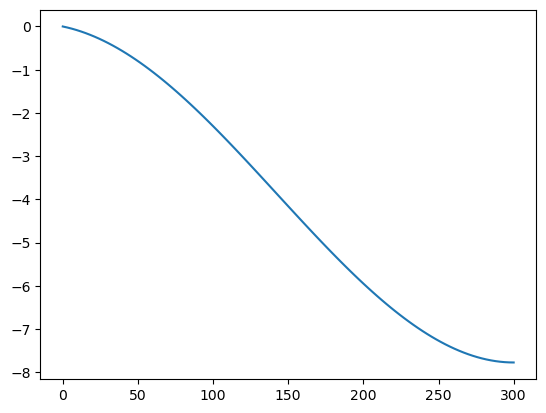

In [6]:
ϕ_lin = np.linspace(0, 300, 100)
Ωϕ_tot_list = [Ωϕ_tot(ϕi, 10, 10) for ϕi in ϕ_lin]
plt.plot(ϕ_lin, Ωϕ_tot_list)
plt.show()

In [7]:
#This is not really global minimization. It is instead local minimization base on three different initial conditions. 
#These initial conditions are chosen based on knowledge of how we think the the minima might be at different μ and μI.
#If one were to do this analysis without any previous knowledge of the system this could lead to finding local minima and wrongly assuming them to be global.

def minimize_ϕρ(μ, μI):
    initial_conditions = [[300, 0], [150, 150], [0, 300]]
    results_ϕρ = [optimize.minimize(Ωϕρ_tot, init, method = 'Powell',  args=(μ, μI), bounds=((0, 350),(0, 350)), tol=1e-3) for init in initial_conditions]
    results_ϕρ_min = [i.fun for i in results_ϕρ]
    results_ϕρ_min_idx = np.where(results_ϕρ_min == np.min(results_ϕρ_min))[0][0]
    result_ϕρ = results_ϕρ[results_ϕρ_min_idx]
    if result_ϕρ.success != True:
        print("The minimization algorithm did not converge at μ = ", μ)
    return result_ϕρ

def minimize_ϕΔ(μ, μI):
    initial_conditions = [[300, 0], [150, 150], [0, 300]]
    results_ϕΔ = [optimize.minimize(ΩϕΔ_tot, init, method = 'Powell',  args=(μ, μI), bounds=((0, 350),(0, 350)), tol=1e-3) for init in initial_conditions]
    #print(results_ϕΔ)
    results_ϕΔ_min = [i.fun for i in results_ϕΔ]
    results_ϕΔ_min_idx = np.where(results_ϕΔ_min == np.min(results_ϕΔ_min))[0][0]
    result_ϕΔ = results_ϕΔ[results_ϕΔ_min_idx]
    if result_ϕΔ.success != True:
        print("The minimization algorithm did not converge at μ = ", μ)
    return result_ϕΔ

def minimize_ϕ_Δ_eq_0(μ, μI):
    initial_conditions = [300, 0]
    results_ϕ = [optimize.minimize(Ωϕ_tot, init, method = 'Powell',  args=(μ, μI), bounds=((0, 350),), tol=1e-3) for init in initial_conditions]
    #print(results_ϕ)
    results_ϕ_min = [i.fun for i in results_ϕ]
    results_ϕ_min_idx = np.where(results_ϕ_min == np.min(results_ϕ_min))[0][0]
    result_ϕ = results_ϕ[results_ϕ_min_idx]
    if result_ϕ.success != True:
        print("The minimization algorithm did not converge at μ = ", μ)
    return result_ϕ

def minimize_ϕΔ_tot(μ, μI):
    min_ϕΔ = minimize_ϕΔ(μ, μI)
    min_ϕ = minimize_ϕ_Δ_eq_0(μ, μI)
    if min_ϕ.fun <= min_ϕΔ.fun:
        return [min_ϕ.x[0],0]
    else:
        return min_ϕΔ.x
    
def total_minimization_function(μ, μI):

    min_ϕρ_data = minimize_ϕρ(μ, μI)
    min_ϕΔ = minimize_ϕΔ_tot(μ, μI)

    Ω_min_val_ρ = min_ϕρ_data.fun
    Ω_min_val_Δ = ΩϕΔ_tot(min_ϕΔ, μ, μI)
    min_ϕρ = min_ϕρ_data.x
    
    if min_ϕρ[1] > 2 and min_ϕΔ[1] < 2:
        return 'ρ'
    
    elif min_ϕρ[1] < 2 and min_ϕΔ[1] > 2:
        return 'Δ'
    
    elif min_ϕρ[1] > 2 and min_ϕΔ[1] > 2:
        if Ω_min_val_ρ < Ω_min_val_Δ:
            return 'ρ'
        else:
            return 'Δ'
    else:
        if min_ϕρ[0] < 298:
            return 'NQM'
        else:
            return 'Vacuum'

In [8]:
print(minimize_ϕΔ_tot(350, 10))

[40.80770847 92.42535516]


In [9]:
μ_lin = np.linspace(300, 350, 30)
minima_list = [minimize_ϕΔ_tot(μi, 100) for μi in tqdm(μ_lin)]
ϕ0_min = [i[0] for i in minima_list]
Δ0_min = [i[1] for i in minima_list]

  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\mathi\AppData\Local\Temp\ipykernel_9048\432776185.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit = 50)
  3%|▎         | 1/30 [00:02<01:00,  2.09s/it]C:\Users\mathi\AppData\Local\Temp\ipykernel_9048\432776185.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit = 50)
100%|██████████| 30/30 

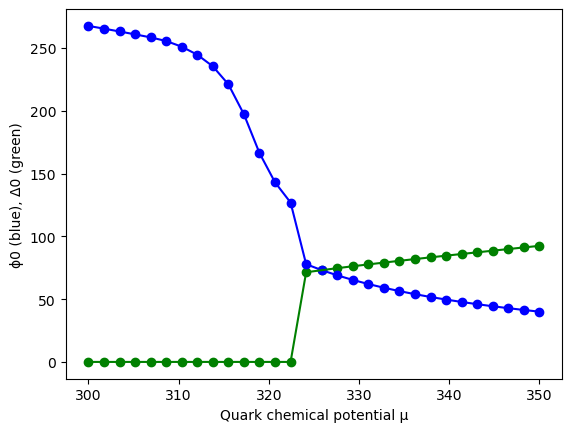

In [10]:
plt.xlabel("Quark chemical potential μ")
plt.ylabel("ϕ0 (blue), Δ0 (green)")
plt.plot(μ_lin, ϕ0_min, c= "blue")
plt.plot(μ_lin, Δ0_min, c= "green")
plt.scatter(μ_lin, Δ0_min, c= "green")
plt.scatter(μ_lin, ϕ0_min, c= "blue")
plt.show()

In [11]:
def vertical_transition_ρ(μ_range, μI_range):
    μI_lin = np.linspace(μI_range[0], μI_range[1], 25)
    
    def transition(μI_current):
        n = 0
        μ_min, μ_max = μ_range
        phase_min = total_minimization_function(μ_min, μI_current)
        phase_max = total_minimization_function(μ_max, μI_current)
        print(phase_min, phase_max)
        if phase_min == phase_max:
            print("Warning: You are in the same phase for lower and upper bound for vertical transition")
            return 0
        else:
            while np.abs(μ_max - μ_min) >= 1/2:
                μ_test = (μ_min + μ_max)/2
                phase = total_minimization_function(μ_test, μI_current)
                print(μ_test, phase)
                if phase == "ρ":
                    μ_min = μ_test
                else:
                    μ_max = μ_test
                n += 1
            return μ_test
    transition_list = [[transition(μIi), μIi] for μIi in tqdm(μI_lin)]
    return transition_list

def horizontal_transition_ρ(μ_range, μI_range):
    μ_lin = np.linspace(μ_range[0], μ_range[1], 25)
    
    def transition(μ_current):
        n = 0
        μI_min, μI_max = μI_range
        phase_min = total_minimization_function(μ_current, μI_min)
        phase_max = total_minimization_function(μ_current, μI_max)
        print(phase_min, phase_max)
        if phase_min == phase_max:
            print("Warning: You are in the same phase for lower and upper bound for horizontal transition")
            return 0
        else:
            while np.abs(μI_max - μI_min) >= 1/2:
                μI_test = (μI_min + μI_max)/2
                phase = total_minimization_function(μ_current, μI_test)
                print(phase, μI_test)
                if phase == "ρ":
                    μI_max = μI_test
                else:
                    μI_min = μI_test
                n += 1
            return μI_test
    transition_list = [[μi, transition(μi)] for μi in tqdm(μ_lin)]
    return transition_list

def vertical_transition_Δ(μ_range, μI_range):
    μI_lin = np.linspace(μI_range[0], μI_range[1], 25)
    
    def transition(μI_current):
        n = 0
        μ_min, μ_max = μ_range
        phase_min = total_minimization_function(μ_min, μI_current)
        phase_max = total_minimization_function(μ_max, μI_current)
        print(phase_min, phase_max)
        if phase_min == phase_max:
            print("Warning: You are in the same phase for lower and upper bound for vertical transition")
            return 0
        else:
            while np.abs(μ_max - μ_min) >= 1/2:
                μ_test = (μ_min + μ_max)/2
                phase = total_minimization_function(μ_test, μI_current)
                print(μ_test, phase)
                if phase == "Δ":
                    μ_max = μ_test
                else:
                    μ_min = μ_test
                n += 1
            return μ_test
    transition_list = [[transition(μIi), μIi] for μIi in tqdm(μI_lin)]
    return transition_list

def vertical_transition_ϕ(μ_range, μI_range):
    μI_lin = np.linspace(μI_range[0], μI_range[1], 25)
    
    def transition(μI_current):
        n = 0
        μ_min, μ_max = μ_range
        phase_min = total_minimization_function(μ_min, μI_current)
        phase_max = total_minimization_function(μ_max, μI_current)
        print(phase_min, phase_max)
        if phase_min == phase_max:
            print("Warning: You are in the same phase for lower and upper bound for vertical transition")
            return 0
        else:
            while np.abs(μ_max - μ_min) >= 1/2:
                μ_test = (μ_min + μ_max)/2
                phase = total_minimization_function(μ_test, μI_current)
                print(μ_test, phase)
                if phase == "Vacuum":
                    μ_min = μ_test
                else:
                    μ_max = μ_test
                n += 1
            return μ_test
    transition_list = [[transition(μIi), μIi] for μIi in tqdm(μI_lin)]
    return transition_list

def horizontal_transition_ϕ(μ_range, μI_range):
    μ_lin = np.linspace(μ_range[0], μ_range[1], 15)
    
    def transition(μ_current):
        n = 0
        μI_min, μI_max = μI_range
        phase_min = total_minimization_function(μ_current, μI_min)
        phase_max = total_minimization_function(μ_current, μI_max)
        print(phase_min, phase_max)
        if phase_min == phase_max:
            print("Warning: You are in the same phase for lower and upper bound for horizontal transition")
            return 0
        else:
            while np.abs(μI_max - μI_min) >= 1/2:
                μI_test = (μI_min + μI_max)/2
                phase = total_minimization_function(μ_current, μI_test)
                print(phase, μI_test)
                if phase == "Vacuum":
                    μI_min = μI_test
                else:
                    μI_max = μI_test
                n += 1
            return μI_test
    transition_list = [[μi, transition(μi)] for μi in tqdm(μ_lin)]
    return transition_list

In [12]:
min_list_1ρ = vertical_transition_ρ([240, 350],[150, 300]) # The range for μI must be large and the range for μ should be close to and cover the transition
min_list_2ρ = horizontal_transition_ρ([150, 250],[100, 250]) # The range for μ should be large and the range for μI should be close and cover the transition
min_list_1Δ = vertical_transition_Δ([225, 450],[0, 300]) # The range for μI must be large and the range for μ should be close to and cover the transition
min_list_1ϕ = vertical_transition_ϕ([140, 350],[0, 130]) # The range for μI must be large and the range for μ should be close to and cover the transition
min_list_2ϕ = horizontal_transition_ϕ([150, 240],[130, 150]) # The range for μI must be large and the range for μ should be close to and cover the transition

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\mathi\AppData\Local\Temp\ipykernel_9048\432776185.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit = 50)
C:\Users\mathi\AppData\Local\Temp\ipykernel_9048\432776185.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit = 50)
C:\Users\mathi\AppData\Local\Temp\ipykernel_9048\432776185.py:25: Int

ρ NQM
295.0 NQM
267.5 NQM
253.75 NQM
246.875 ρ
250.3125 ρ
252.03125 NQM
251.171875 NQM


  4%|▍         | 1/25 [00:37<14:58, 37.43s/it]

250.7421875 NQM
ρ NQM
295.0 NQM
267.5 NQM
253.75 ρ
260.625 NQM
257.1875 NQM
255.46875 NQM
254.609375 ρ


  8%|▊         | 2/25 [01:16<14:44, 38.46s/it]

255.0390625 ρ
ρ NQM
295.0 NQM
267.5 NQM
253.75 ρ
260.625 NQM
257.1875 ρ
258.90625 NQM
258.046875 ρ


 12%|█▏        | 3/25 [01:55<14:15, 38.87s/it]

258.4765625 NQM
ρ NQM
295.0 NQM
267.5 NQM
253.75 ρ
260.625 NQM
257.1875 ρ
258.90625 ρ
259.765625 ρ


 16%|█▌        | 4/25 [02:34<13:34, 38.80s/it]

260.1953125 ρ
ρ NQM
295.0 NQM
267.5 NQM
253.75 ρ
260.625 ρ
264.0625 NQM
262.34375 NQM
261.484375 ρ


 20%|██        | 5/25 [03:15<13:07, 39.40s/it]

261.9140625 ρ
ρ NQM
295.0 NQM
267.5 NQM
253.75 ρ
260.625 ρ
264.0625 NQM
262.34375 ρ
263.203125 ρ


 24%|██▍       | 6/25 [03:56<12:40, 40.03s/it]

263.6328125 NQM
ρ NQM
295.0 NQM
267.5 NQM
253.75 ρ
260.625 ρ
264.0625 ρ
265.78125 NQM
264.921875 NQM


 28%|██▊       | 7/25 [04:33<11:43, 39.10s/it]

264.4921875 NQM
ρ NQM
295.0 NQM
267.5 NQM
253.75 ρ
260.625 ρ
264.0625 ρ
265.78125 NQM
264.921875 NQM


 32%|███▏      | 8/25 [05:12<11:02, 38.96s/it]

264.4921875 ρ
ρ NQM
295.0 NQM
267.5 NQM
253.75 ρ
260.625 ρ
264.0625 ρ
265.78125 ρ
266.640625 NQM


 36%|███▌      | 9/25 [05:50<10:20, 38.77s/it]

266.2109375 NQM
ρ NQM
295.0 NQM
267.5 NQM
253.75 ρ
260.625 ρ
264.0625 ρ
265.78125 ρ
266.640625 NQM


 40%|████      | 10/25 [06:27<09:32, 38.16s/it]

266.2109375 ρ
ρ NQM
295.0 NQM
267.5 NQM
253.75 ρ
260.625 ρ
264.0625 ρ
265.78125 ρ
266.640625 ρ


 44%|████▍     | 11/25 [07:07<09:00, 38.61s/it]

267.0703125 ρ
ρ NQM
295.0 NQM
267.5 ρ
281.25 NQM
274.375 NQM
270.9375 NQM
269.21875 NQM
268.359375 NQM


 48%|████▊     | 12/25 [07:48<08:31, 39.35s/it]

267.9296875 NQM
ρ NQM
295.0 NQM
267.5 ρ
281.25 NQM
274.375 NQM
270.9375 NQM
269.21875 NQM
268.359375 NQM


 52%|█████▏    | 13/25 [08:28<07:57, 39.79s/it]

267.9296875 ρ
ρ NQM
295.0 NQM
267.5 ρ
281.25 NQM
274.375 NQM
270.9375 NQM
269.21875 NQM
268.359375 ρ


 56%|█████▌    | 14/25 [09:08<07:18, 39.85s/it]

268.7890625 NQM
ρ NQM
295.0 NQM
267.5 ρ
281.25 NQM
274.375 NQM
270.9375 NQM
269.21875 NQM
268.359375 ρ


 60%|██████    | 15/25 [09:49<06:40, 40.07s/it]

268.7890625 NQM
ρ NQM
295.0 NQM
267.5 ρ
281.25 NQM
274.375 NQM
270.9375 NQM
269.21875 NQM
268.359375 ρ


 64%|██████▍   | 16/25 [10:28<05:58, 39.86s/it]

268.7890625 NQM
ρ NQM
295.0 NQM
267.5 ρ
281.25 NQM
274.375 NQM
270.9375 NQM
269.21875 NQM
268.359375 ρ


 68%|██████▊   | 17/25 [11:09<05:21, 40.18s/it]

268.7890625 NQM
ρ NQM
295.0 NQM
267.5 ρ
281.25 NQM
274.375 NQM
270.9375 NQM
269.21875 NQM
268.359375 ρ


 72%|███████▏  | 18/25 [11:50<04:42, 40.35s/it]

268.7890625 NQM
ρ NQM
295.0 NQM
267.5 ρ
281.25 NQM
274.375 NQM
270.9375 NQM
269.21875 NQM
268.359375 ρ


 76%|███████▌  | 19/25 [12:32<04:05, 40.92s/it]

268.7890625 NQM
ρ NQM
295.0 NQM
267.5 ρ
281.25 NQM
274.375 NQM
270.9375 NQM
269.21875 NQM
268.359375 NQM


 80%|████████  | 20/25 [13:16<03:28, 41.71s/it]

267.9296875 ρ
ρ NQM
295.0 NQM
267.5 ρ


C:\Users\mathi\AppData\Local\Temp\ipykernel_9048\432776185.py:64: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral_bar_m, err_bar_m = integrate.quad(integrand_bar_m, 0, Λ_cutoff)


281.25 NQM
274.375 NQM
270.9375 NQM
269.21875 NQM
268.359375 NQM


 84%|████████▍ | 21/25 [13:56<02:45, 41.37s/it]

267.9296875 ρ
ρ NQM
295.0 NQM
267.5 ρ
281.25 NQM
274.375 NQM
270.9375 NQM
269.21875 NQM
268.359375 NQM


 88%|████████▊ | 22/25 [14:38<02:04, 41.46s/it]

267.9296875 NQM
ρ NQM
295.0 NQM
267.5 ρ
281.25 NQM
274.375 NQM
270.9375 NQM
269.21875 NQM
268.359375 NQM


 92%|█████████▏| 23/25 [15:17<01:21, 40.86s/it]

267.9296875 NQM
ρ NQM
295.0 NQM
267.5 NQM
253.75 ρ
260.625 ρ
264.0625 ρ
265.78125 ρ
266.640625 ρ


 96%|█████████▌| 24/25 [15:52<00:38, 38.89s/it]

267.0703125 ρ
ρ NQM
295.0 NQM
267.5 NQM
253.75 ρ
260.625 ρ
264.0625 ρ
265.78125 ρ
266.640625 ρ


100%|██████████| 25/25 [16:25<00:00, 39.42s/it]


267.0703125 NQM


  0%|          | 0/25 [00:00<?, ?it/s]

Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


  4%|▍         | 1/25 [00:19<07:40, 19.17s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


  8%|▊         | 2/25 [00:38<07:17, 19.03s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 12%|█▏        | 3/25 [00:56<06:57, 18.97s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 16%|█▌        | 4/25 [01:15<06:37, 18.91s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 20%|██        | 5/25 [01:34<06:15, 18.76s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 24%|██▍       | 6/25 [01:52<05:54, 18.67s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 28%|██▊       | 7/25 [02:11<05:38, 18.80s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 32%|███▏      | 8/25 [02:31<05:22, 18.99s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 36%|███▌      | 9/25 [02:50<05:07, 19.20s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 40%|████      | 10/25 [03:09<04:47, 19.15s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 44%|████▍     | 11/25 [03:29<04:28, 19.16s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 48%|████▊     | 12/25 [03:48<04:11, 19.37s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 52%|█████▏    | 13/25 [04:08<03:53, 19.42s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 56%|█████▌    | 14/25 [04:27<03:33, 19.43s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 60%|██████    | 15/25 [04:48<03:16, 19.68s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 64%|██████▍   | 16/25 [05:10<03:04, 20.50s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 68%|██████▊   | 17/25 [05:32<02:48, 21.02s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 72%|███████▏  | 18/25 [05:55<02:29, 21.42s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 76%|███████▌  | 19/25 [06:18<02:11, 21.89s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 80%|████████  | 20/25 [06:42<01:52, 22.58s/it]

ρ 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
ρ 141.015625
ρ 140.4296875


 84%|████████▍ | 21/25 [07:09<01:36, 24.08s/it]

Vacuum 140.13671875
Vacuum ρ
ρ 175.0
Vacuum 137.5
ρ 156.25
ρ 146.875
ρ 142.1875
Vacuum 139.84375
Vacuum 141.015625
ρ 141.6015625


 88%|████████▊ | 22/25 [07:38<01:16, 25.48s/it]

Vacuum 141.30859375
Vacuum ρ
ρ 175.0
NQM 137.5
ρ 156.25
ρ 146.875
NQM 142.1875
ρ 144.53125
ρ 143.359375
NQM 142.7734375


 92%|█████████▏| 23/25 [08:09<00:54, 27.21s/it]

NQM 143.06640625
Vacuum ρ
ρ 175.0
NQM 137.5
ρ 156.25
ρ 146.875
NQM 142.1875
NQM 144.53125
ρ 145.703125
NQM 145.1171875


 96%|█████████▌| 24/25 [08:46<00:29, 29.89s/it]

NQM 145.41015625
Vacuum ρ
ρ 175.0
NQM 137.5
ρ 156.25
NQM 146.875
ρ 151.5625
NQM 149.21875
ρ 150.390625
ρ 149.8046875


100%|██████████| 25/25 [09:23<00:00, 22.54s/it]


ρ 149.51171875


  0%|          | 0/25 [00:00<?, ?it/s]

Vacuum Δ
337.5 Δ
281.25 Vacuum
309.375 Δ
295.3125 Vacuum
302.34375 Vacuum
305.859375 NQM
307.6171875 NQM
308.49609375 Δ


  4%|▍         | 1/25 [00:44<17:51, 44.65s/it]

308.056640625 Δ
Vacuum Δ
337.5 Δ
281.25 Vacuum
309.375 NQM
323.4375 Δ
316.40625 Δ
312.890625 NQM
314.6484375 Δ
313.76953125 Δ


  8%|▊         | 2/25 [01:33<18:04, 47.17s/it]

313.330078125 NQM
Vacuum Δ
337.5 Δ
281.25 Vacuum
309.375 NQM
323.4375 Δ
316.40625 Δ
312.890625 NQM
314.6484375 NQM
315.52734375 NQM


 12%|█▏        | 3/25 [02:20<17:17, 47.18s/it]

315.966796875 Δ
Vacuum Δ
337.5 Δ
281.25 Vacuum
309.375 NQM
323.4375 Δ
316.40625 Δ
312.890625 NQM
314.6484375 NQM
315.52734375 NQM


 16%|█▌        | 4/25 [03:09<16:44, 47.84s/it]

315.966796875 Δ
Vacuum Δ
337.5 Δ
281.25 Vacuum
309.375 NQM
323.4375 Δ
316.40625 Δ
312.890625 NQM
314.6484375 NQM
315.52734375 NQM


 20%|██        | 5/25 [04:01<16:23, 49.19s/it]

315.966796875 NQM
Vacuum Δ
337.5 Δ
281.25 NQM
309.375 NQM
323.4375 Δ
316.40625 NQM
319.921875 Δ
318.1640625 Δ
317.28515625 Δ


 24%|██▍       | 6/25 [04:48<15:19, 48.39s/it]

316.845703125 Δ
Vacuum Δ
337.5 Δ
281.25 NQM
309.375 NQM
323.4375 Δ
316.40625 NQM
319.921875 Δ
318.1640625 Δ
317.28515625 NQM


 28%|██▊       | 7/25 [05:35<14:26, 48.17s/it]

317.724609375 Δ
Vacuum Δ
337.5 Δ
281.25 NQM
309.375 NQM
323.4375 Δ
316.40625 NQM
319.921875 Δ
318.1640625 NQM
319.04296875 NQM


 32%|███▏      | 8/25 [06:21<13:27, 47.50s/it]

319.482421875 Δ
Vacuum Δ
337.5 Δ
281.25 NQM
309.375 NQM
323.4375 NQM
330.46875 Δ
326.953125 Δ
325.1953125 Δ
324.31640625 Δ


 36%|███▌      | 9/25 [07:05<12:20, 46.28s/it]

323.876953125 Δ
Vacuum Δ
337.5 Δ
281.25 NQM
309.375 NQM
323.4375 NQM
330.46875 NQM
333.984375 Δ
332.2265625 Δ
331.34765625 NQM


 40%|████      | 10/25 [07:51<11:34, 46.29s/it]

331.787109375 NQM
Vacuum Δ
337.5 NQM
393.75 Δ
365.625 Δ
351.5625 Δ
344.53125 Δ
341.015625 NQM
342.7734375 Δ
341.89453125 NQM


 44%|████▍     | 11/25 [08:27<10:04, 43.19s/it]

342.333984375 Δ
Vacuum Δ
337.5 NQM
393.75 Δ
365.625 Δ
351.5625 NQM
358.59375 Δ
355.078125 Δ
353.3203125 NQM
354.19921875 Δ


 48%|████▊     | 12/25 [08:58<08:30, 39.25s/it]

353.759765625 Δ
ρ Δ
337.5 NQM
393.75 Δ
365.625 Δ
351.5625 NQM
358.59375 NQM
362.109375 NQM
363.8671875 NQM
364.74609375 NQM


 52%|█████▏    | 13/25 [09:25<07:08, 35.72s/it]

365.185546875 NQM
ρ Δ
337.5 NQM
393.75 Δ
365.625 NQM
379.6875 Δ
372.65625 NQM
376.171875 NQM
377.9296875 Δ
377.05078125 NQM


 56%|█████▌    | 14/25 [09:53<06:05, 33.22s/it]

377.490234375 NQM
ρ Δ
337.5 NQM
393.75 Δ
365.625 NQM
379.6875 NQM
386.71875 NQM
390.234375 Δ
388.4765625 NQM
389.35546875 NQM


 60%|██████    | 15/25 [10:23<05:22, 32.29s/it]

389.794921875 NQM
ρ Δ
337.5 NQM
393.75 NQM
421.875 Δ
407.8125 Δ
400.78125 NQM
404.296875 Δ
402.5390625 NQM
403.41796875 Δ


 64%|██████▍   | 16/25 [10:53<04:43, 31.53s/it]

402.978515625 NQM
ρ Δ
337.5 NQM
393.75 NQM
421.875 Δ
407.8125 NQM
414.84375 NQM
418.359375 Δ
416.6015625 NQM
417.48046875 Δ


 68%|██████▊   | 17/25 [11:22<04:06, 30.76s/it]

417.041015625 Δ
ρ Δ
337.5 NQM
393.75 NQM
421.875 NQM
435.9375 Δ
428.90625 NQM
432.421875 Δ
430.6640625 NQM
431.54296875 Δ


 72%|███████▏  | 18/25 [11:52<03:35, 30.81s/it]

431.103515625 Δ
ρ Δ
337.5 NQM
393.75 NQM
421.875 NQM
435.9375 NQM
442.96875 NQM
446.484375 Δ
444.7265625 NQM
445.60546875 Δ


 76%|███████▌  | 19/25 [12:24<03:05, 30.88s/it]

445.166015625 NQM
ρ NQM
337.5 NQM
393.75 NQM
421.875 NQM
435.9375 NQM
442.96875 NQM
446.484375 NQM
448.2421875 NQM
449.12109375 NQM


 80%|████████  | 20/25 [12:59<02:41, 32.22s/it]

449.560546875 NQM
ρ NQM
337.5 NQM
393.75 NQM
421.875 NQM
435.9375 NQM
442.96875 NQM
446.484375 NQM
448.2421875 NQM
449.12109375 NQM


 84%|████████▍ | 21/25 [13:43<02:22, 35.69s/it]

449.560546875 NQM
ρ NQM
337.5 NQM
393.75 NQM
421.875 NQM
435.9375 NQM
442.96875 NQM
446.484375 NQM
448.2421875 NQM
449.12109375 NQM


 88%|████████▊ | 22/25 [14:25<01:53, 37.72s/it]

449.560546875 NQM
ρ NQM
337.5 NQM
393.75 NQM
421.875 NQM
435.9375 NQM
442.96875 NQM
446.484375 NQM
448.2421875 NQM
449.12109375 NQM


 92%|█████████▏| 23/25 [15:07<01:18, 39.12s/it]

449.560546875 NQM
ρ NQM
337.5 NQM
393.75 NQM
421.875 NQM
435.9375 NQM
442.96875 NQM
446.484375 NQM
448.2421875 NQM
449.12109375 NQM


 96%|█████████▌| 24/25 [15:50<00:40, 40.06s/it]

449.560546875 NQM
ρ NQM
337.5 NQM
393.75 NQM
421.875 NQM
435.9375 NQM
442.96875 NQM
446.484375 NQM
448.2421875 NQM
449.12109375 NQM


100%|██████████| 25/25 [16:31<00:00, 39.67s/it]


449.560546875 NQM


  0%|          | 0/25 [00:00<?, ?it/s]

Vacuum Δ
245.0 Vacuum
297.5 Vacuum
323.75 Δ
310.625 Δ
304.0625 Vacuum
307.34375 NQM
305.703125 Vacuum
306.5234375 NQM


  4%|▍         | 1/25 [00:48<19:35, 48.97s/it]

306.11328125 NQM
Vacuum Δ
245.0 Vacuum
297.5 Vacuum
323.75 Δ
310.625 Δ
304.0625 Vacuum
307.34375 NQM
305.703125 NQM
304.8828125 Vacuum


  8%|▊         | 2/25 [01:36<18:27, 48.17s/it]

305.29296875 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 Vacuum
323.75 Δ
310.625 NQM
304.0625 Vacuum
307.34375 NQM
305.703125 NQM
304.8828125 NQM


 12%|█▏        | 3/25 [02:24<17:40, 48.21s/it]

304.47265625 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 Vacuum
323.75 Δ
310.625 NQM
304.0625 NQM
300.78125 Vacuum
302.421875 NQM
301.6015625 Vacuum


 16%|█▌        | 4/25 [03:11<16:40, 47.66s/it]

302.01171875 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 Vacuum
323.75 Δ
310.625 NQM
304.0625 NQM
300.78125 NQM
299.140625 Vacuum
299.9609375 NQM


 20%|██        | 5/25 [03:58<15:50, 47.54s/it]

299.55078125 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 Vacuum
284.375 Vacuum
290.9375 Vacuum
294.21875 Vacuum
295.859375 Vacuum
296.6796875 Vacuum


 24%|██▍       | 6/25 [04:40<14:25, 45.53s/it]

297.08984375 NQM
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 Vacuum
284.375 Vacuum
290.9375 Vacuum
294.21875 NQM
292.578125 Vacuum
293.3984375 Vacuum


 28%|██▊       | 7/25 [05:20<13:05, 43.64s/it]

293.80859375 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 Vacuum
284.375 Vacuum
290.9375 Vacuum
294.21875 NQM
292.578125 NQM
291.7578125 NQM


 32%|███▏      | 8/25 [05:58<11:54, 42.01s/it]

291.34765625 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 Vacuum
284.375 Vacuum
290.9375 NQM
287.65625 Vacuum
289.296875 NQM
288.4765625 Vacuum


 36%|███▌      | 9/25 [06:37<10:55, 40.99s/it]

288.88671875 NQM
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 Vacuum
284.375 Vacuum
290.9375 NQM
287.65625 NQM
286.015625 Vacuum
286.8359375 NQM


 40%|████      | 10/25 [07:16<10:03, 40.25s/it]

286.42578125 NQM
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 Vacuum
284.375 NQM
277.8125 Vacuum
281.09375 Vacuum
282.734375 Vacuum
283.5546875 NQM


 44%|████▍     | 11/25 [07:58<09:32, 40.93s/it]

283.14453125 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 Vacuum
284.375 NQM
277.8125 Vacuum
281.09375 NQM
279.453125 Vacuum
280.2734375 Vacuum


 48%|████▊     | 12/25 [08:37<08:44, 40.35s/it]

280.68359375 NQM
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 Vacuum
284.375 NQM
277.8125 Vacuum
281.09375 NQM
279.453125 NQM
278.6328125 NQM


 52%|█████▏    | 13/25 [09:16<07:58, 39.92s/it]

278.22265625 NQM
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 Vacuum
284.375 NQM
277.8125 NQM
274.53125 Vacuum
276.171875 NQM
275.3515625 NQM


 56%|█████▌    | 14/25 [09:56<07:19, 39.99s/it]

274.94140625 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 Vacuum
284.375 NQM
277.8125 NQM
274.53125 NQM
272.890625 NQM
272.0703125 Vacuum


 60%|██████    | 15/25 [10:34<06:34, 39.42s/it]

272.48046875 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 NQM
258.125 Vacuum
264.6875 Vacuum
267.96875 Vacuum
269.609375 Vacuum
270.4296875 NQM


 64%|██████▍   | 16/25 [11:13<05:53, 39.29s/it]

270.01953125 NQM
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 NQM
258.125 Vacuum
264.6875 Vacuum
267.96875 NQM
266.328125 Vacuum
267.1484375 NQM


 68%|██████▊   | 17/25 [11:53<05:14, 39.33s/it]

266.73828125 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 NQM
258.125 Vacuum
264.6875 NQM
261.40625 Vacuum
263.046875 Vacuum
263.8671875 Vacuum


 72%|███████▏  | 18/25 [12:33<04:36, 39.48s/it]

264.27734375 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 NQM
258.125 Vacuum
264.6875 NQM
261.40625 Vacuum
263.046875 NQM
262.2265625 NQM


 76%|███████▌  | 19/25 [13:12<03:56, 39.36s/it]

261.81640625 NQM
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 NQM
258.125 Vacuum
264.6875 NQM
261.40625 NQM
259.765625 NQM
258.9453125 Vacuum


 80%|████████  | 20/25 [13:52<03:17, 39.53s/it]

259.35546875 NQM
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 NQM
258.125 NQM
251.5625 Vacuum
254.84375 Vacuum
256.484375 NQM
255.6640625 Vacuum


 84%|████████▍ | 21/25 [14:30<02:36, 39.07s/it]

256.07421875 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 NQM
258.125 NQM
251.5625 Vacuum
254.84375 NQM
253.203125 Vacuum
254.0234375 NQM


 88%|████████▊ | 22/25 [15:07<01:56, 38.71s/it]

253.61328125 NQM
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 NQM
258.125 NQM
251.5625 NQM
248.28125 Vacuum
249.921875 Vacuum
250.7421875 Vacuum


 92%|█████████▏| 23/25 [15:44<01:16, 38.18s/it]

251.15234375 NQM
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 NQM
258.125 NQM
251.5625 NQM
248.28125 NQM
246.640625 Vacuum
247.4609375 Vacuum


 96%|█████████▌| 24/25 [16:25<00:38, 38.85s/it]

247.87109375 Vacuum
Vacuum Δ
245.0 Vacuum
297.5 NQM
271.25 NQM
258.125 NQM
251.5625 NQM
248.28125 NQM
246.640625 NQM
245.8203125 NQM


100%|██████████| 25/25 [17:04<00:00, 40.98s/it]


245.41015625 NQM


  0%|          | 0/15 [00:00<?, ?it/s]

Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


  7%|▋         | 1/15 [00:13<03:12, 13.78s/it]

Vacuum 139.6875
Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


 13%|█▎        | 2/15 [00:27<03:00, 13.88s/it]

Vacuum 139.6875
Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


 20%|██        | 3/15 [00:41<02:44, 13.69s/it]

Vacuum 139.6875
Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


 27%|██▋       | 4/15 [00:54<02:30, 13.64s/it]

Vacuum 139.6875
Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


 33%|███▎      | 5/15 [01:08<02:16, 13.61s/it]

Vacuum 139.6875
Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


 40%|████      | 6/15 [01:22<02:03, 13.68s/it]

Vacuum 139.6875
Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


 47%|████▋     | 7/15 [01:35<01:48, 13.54s/it]

Vacuum 139.6875
Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


 53%|█████▎    | 8/15 [01:49<01:36, 13.73s/it]

Vacuum 139.6875
Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


 60%|██████    | 9/15 [02:03<01:22, 13.67s/it]

Vacuum 139.6875
Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


 67%|██████▋   | 10/15 [02:16<01:08, 13.66s/it]

Vacuum 139.6875
Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


 73%|███████▎  | 11/15 [02:31<00:56, 14.14s/it]

Vacuum 139.6875
Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


 80%|████████  | 12/15 [02:47<00:43, 14.53s/it]

Vacuum 139.6875
Vacuum ρ
ρ 140.0
Vacuum 135.0
Vacuum 137.5
Vacuum 138.75
Vacuum 139.375


 87%|████████▋ | 13/15 [03:02<00:29, 14.83s/it]

Vacuum 139.6875
Vacuum ρ
Vacuum 140.0
ρ 145.0
ρ 142.5
ρ 141.25
ρ 140.625


 93%|█████████▎| 14/15 [03:22<00:16, 16.15s/it]

Vacuum 140.3125
Vacuum ρ
Vacuum 140.0
ρ 145.0
ρ 142.5
NQM 141.25
Vacuum 140.625


100%|██████████| 15/15 [03:43<00:00, 14.90s/it]

NQM 140.9375


In [13]:
μ_min_list_1ρ = [i[0] for i in min_list_1ρ]
μI_min_list_1ρ = [i[1] for i in min_list_1ρ]
μ_min_list_2ρ = [i[0] for i in min_list_2ρ]
μI_min_list_2ρ = [i[1] for i in min_list_2ρ]

μ_min_list_ρ = μ_min_list_2ρ + μ_min_list_1ρ
μI_min_list_ρ = μI_min_list_2ρ + μI_min_list_1ρ 

In [14]:
μ_min_list_Δ = [i[0] for i in min_list_1Δ]
μI_min_list_Δ = [i[1] for i in min_list_1Δ]

In [15]:
μ_min_list_ϕ1 = [i[0] for i in min_list_1ϕ]
μI_min_list_ϕ1 = [i[1] for i in min_list_1ϕ]
μ_min_list_ϕ2 = [i[0] for i in min_list_2ϕ]
μI_min_list_ϕ2 = [i[1] for i in min_list_2ϕ]

μ_min_list_ϕ2.reverse()
μI_min_list_ϕ2.reverse()

μ_min_list_ϕ = μ_min_list_ϕ1 + μ_min_list_ϕ2
μI_min_list_ϕ = μI_min_list_ϕ1 + μI_min_list_ϕ2

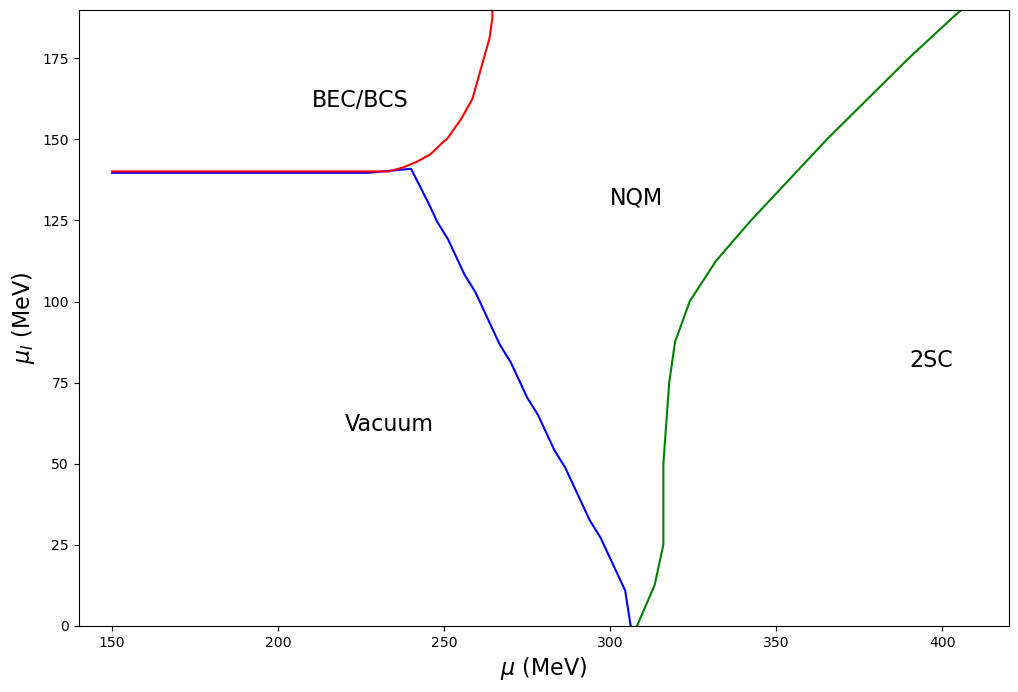

In [16]:
fig = plt.figure(figsize=(12,8))

plt.plot(μ_min_list_Δ, μI_min_list_Δ, c= "green")
plt.plot(μ_min_list_ϕ, μI_min_list_ϕ, c= "blue")
plt.plot(μ_min_list_ρ, μI_min_list_ρ, c= "red")
#plt.scatter(μ_min_list_ρ, μI_min_list_ρ, c= "red", s = 5)
#plt.scatter(μ_min_list_Δ, μI_min_list_Δ, c= "green", s = 5)
#plt.scatter(μ_min_list_ϕ, μI_min_list_ϕ, c= "blue", s = 5)

plt.xlabel(r'$\mu$' + " (MeV)", fontsize=16)
plt.ylabel(r'$\mu_I$' + " (MeV)", fontsize=16)
plt.xlim(140, 420)
plt.ylim(0, 190)
plt.text(220, 60, 'Vacuum', fontsize = 16)
plt.text(210, 160, 'BEC/BCS', fontsize = 16)
plt.text(390, 80, '2SC', fontsize = 16)
plt.text(300, 130, 'NQM', fontsize = 16)
plt.savefig("mu_muI_phase_diagram_set2.pdf")
plt.show()